# Time Series

## Imports and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [208]:
df = pd.read_csv('./Data/all_sentiment.csv', parse_dates=['created_at'], infer_datetime_format=True)
pd.set_option('display.max_columns', 50)

## Tack on state policy dates

In the next section, we will tack on state policy dates to the main data set.

In [207]:
sip = pd.read_csv('./data/state_policies_new.csv', parse_dates=['date_stay_home', 'date_end_stay_home'], infer_datetime_format=True)
sip.head()

,state_short,state_full,date_shelter_announced,date_shelter_effective,date_stay_home,date_travel_quarentine,date_nonessential_close,date_large_gather_ban,date_school_close,date_rest_limit,primary_delay,date_emergency_dec,date_end_stay_home,date_end_travel_quarentine,date_open_nonessential,date_end_large_gather_ban,date_end_school_close,date_end_rest_limit,date_mask_required,mask_required,shelter_issued,stay_home_order,travel_quarentine_issued,nonessential_close_order,large_gather_ban_issued,school_closures,rest_limit_issued,emergency_declaration,end_stay_home,end_travel_quarentine,open_nonessential,end_large_gather_ban,schools_open_in_person,end_rest_limit
0,NY,New York,2020-03-20,2020-03-22,2020-03-22,2020-06-25 00:00:00,2020-03-22,2020-03-22,2020-03-20,2020-03-16,Canceled,2020-03-07,2020-06-27,NaN,2020-05-14,2020-05-22,NaN,2020-06-22,2020-04-15,Entire State,1,1,1,1,1,1,1,1,1,0,1,1,0,1
1,MA,Massachusetts,2020-03-23,2020-03-24,NaT,2020-03-27 00:00:00,2020-03-24,2020-03-17,2020-03-16,2020-03-17,NaN,2020-03-10,NaT,NaN,2020-05-19,NaN,NaN,2020-06-08,2020-05-06,Entire State,1,0,1,1,1,1,1,1,0,0,1,0,0,1
2,RI,Rhode Island,2020-03-28,2020-03-28,2020-03-28,2020-03-28 00:00:00,2020-03-30,2020-03-28,2020-03-23,2020-03-17,Postponed,2020-03-09,2020-05-09,NaN,2020-05-09,2020-06-01,NaN,2020-05-30,2020-04-20,Entire State,1,1,1,1,1,1,1,1,1,0,1,1,0,1
3,NH,New Hampshire,2020-03-26,2020-03-27,2020-03-27,NaN,2020-03-27,2020-03-16,2020-03-16,2020-03-16,NaN,2020-03-13,2020-06-15,NaN,2020-05-11,NaN,NaN,2020-05-18,NaN,Parts of State,1,1,0,1,1,1,1,1,1,0,1,0,0,1
4,ME,Maine,2020-03-31,2020-04-02,2020-04-01,2020-04-03 00:00:00,2020-03-25,2020-03-18,2020-04-02,2020-03-18,Postponed,2020-03-15,NaT,NaN,2020-05-01,2020-06-01,NaN,2020-06-01,2020-05-01,Entire State,1,1,1,1,1,1,1,1,0,0,1,1,0,1


In [209]:
df = pd.merge(df, sip[['state_short', 'date_stay_home', 'date_end_stay_home']], left_on = 'state', right_on = 'state_short', how = 'left')

In [210]:
df = df.drop(columns = ['state_short'])

In [7]:
df.head(2)

,created_at,favorite_count,status_id,lang,place_full_name,retweet_count,text,account_created_at,screen_name,followers_count,friends_count,verified,city,state,is_reply,is_retweet,country_code,place_type,neg,neu,pos,compound,date_stay_home,date_end_stay_home
0,2020-08-10 04:44:47+00:00,0,1292683286603542529,en,"Dallas, TX",0,Matching our swimsuits may have been a step to...,2009-06-25 19:58:31+00:00,LoraleeL,1415,610,False,Dallas,TX,False,False,US,unspecified,0.000,0.871,0.129,0.7783,2020-04-02,2020-04-30
1,2020-08-10 05:46:03+00:00,0,1292698706261680128,en,"Houston, TX",0,#MaybeInYourCity All Month Long @_blessed_hand...,2009-11-20 22:25:08+00:00,_blessed_hands_,987,1091,False,Houston,TX,False,False,US,unspecified,0.048,0.825,0.128,0.4939,2020-04-02,2020-04-30


## Time-Series Sentiment

In the next section, we will look at sentiment as a function of time.  Given that many of the shelter-in-place orders were signed into law in April, we want to see if there were any negative or positive sentiments associated around those dates.

In [219]:
def sentiment_w_policy(sentiment_df, metric='compound', state_code=None):
    """input a state data set, metric, and the state name and you get a time-series graph with policy dates denoted"""
   
    # metric dictionary for title
    all_metrics = {'compound': 'Compound', 'pos': 'Positive', 'neu': 'Neutral', 'neg': 'Negative'}

    # changing 'created_at' datetime to just a date and set that column as index
    state_df = sentiment_df.loc[sentiment_df['state'] == state_code,].copy().reset_index(drop=True)
    state_df['date'] = state_df['created_at'].dt.date
    state_df['date'] = pd.to_datetime(state_df['date'])
    state_df.set_index('date', inplace=True)

    # group tweets by day and average, then take a rolling 7 day average 
    resample = state_df.resample('D').mean().copy()
    mean_by_day = resample.rolling(7).mean().copy()

    # plot the 7 day rolling average and the shelter-in-place policy start and end dates as vertical lines
    plt.figure(figsize=(12,7))
    plt.plot(mean_by_day[metric])
    plt.axvline(pd.to_datetime(state_df.iloc[0, -2]), c='r', label='Shelter-In-Place Start Date')
    # if there is no end date, do not plot anything
    try:
        plt.axvline(pd.to_datetime(state_df.iloc[0, -1]), c='g', label='Shelter-In-Place End Date')
    except:
        pass
    
    # legend for shelter in place start and end date and plotting x- and y-axis labels
    plt.legend()
    plt.xlabel('Month', fontsize=15)
    plt.ylabel('VADER Score', fontsize=15)
    plt.title('7 Day Average ' + all_metrics[metric] + ' VADER Scores as a Time-Series in ' + state_code, fontsize=20)
    plt.show();
        

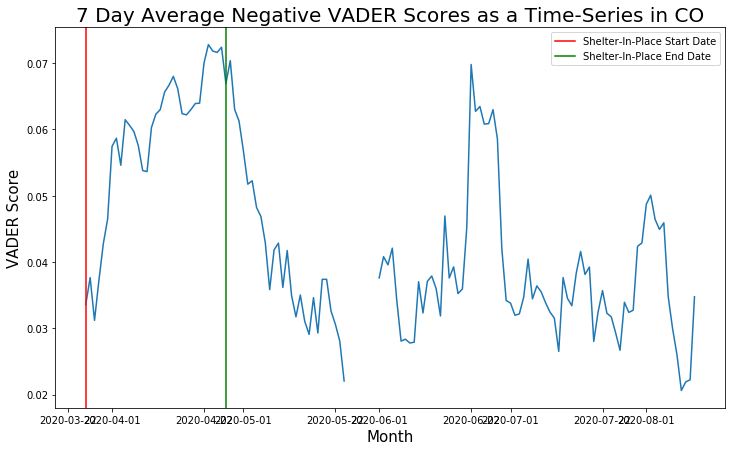

In [220]:
sentiment_w_policy(df, metric='neg', state_code='CO')

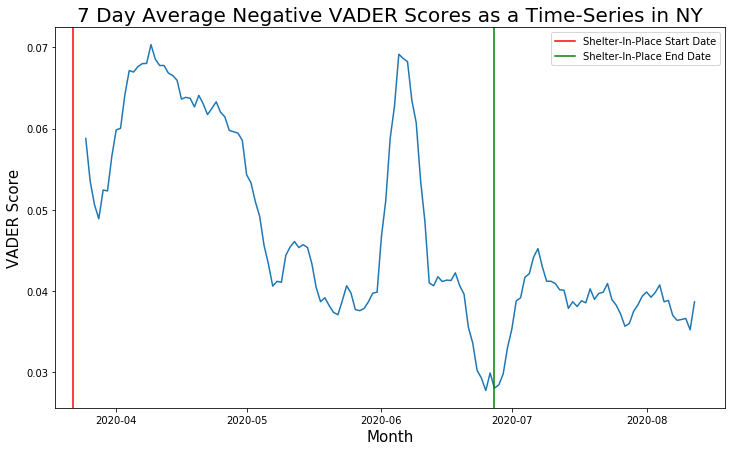

In [221]:
sentiment_w_policy(df, metric='neg', state_code='NY')

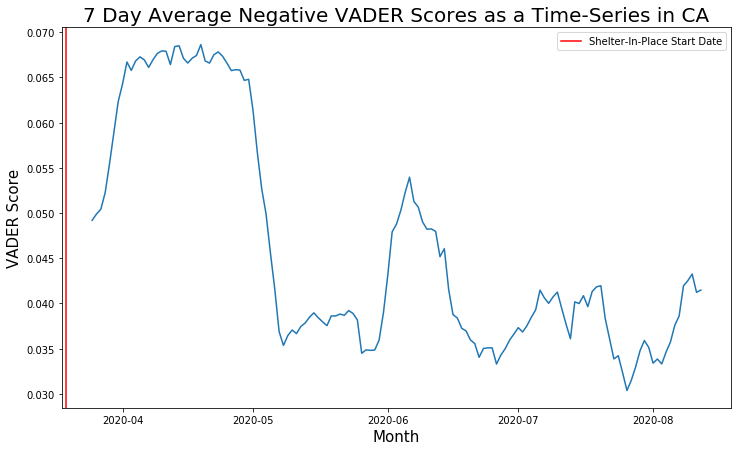

In [222]:
sentiment_w_policy(df, metric='neg', state_code='CA')

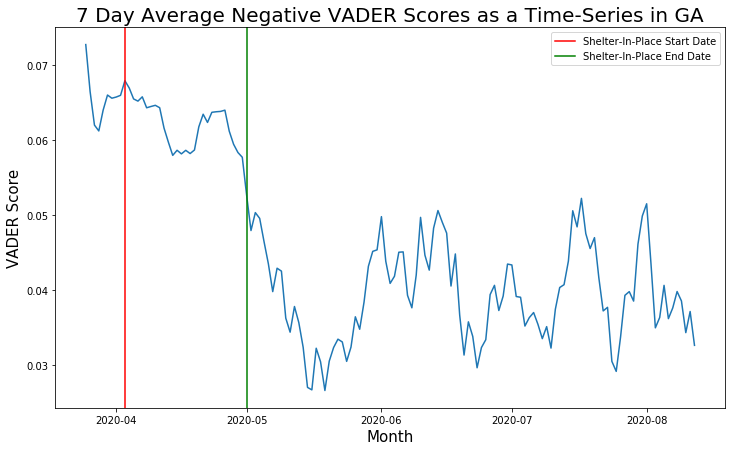

In [223]:
sentiment_w_policy(df, metric='neg', state_code='GA')

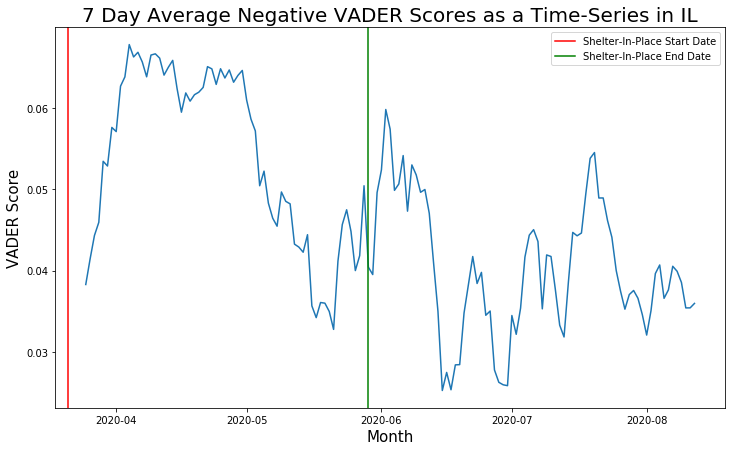

In [224]:
sentiment_w_policy(df, metric='neg', state_code='IL')

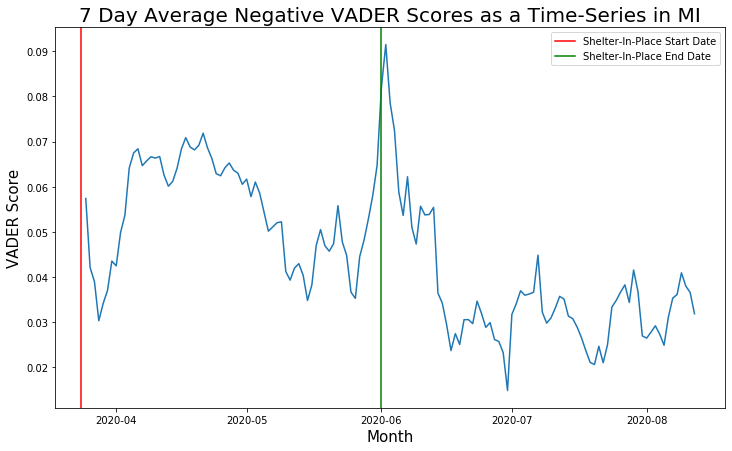

In [225]:
sentiment_w_policy(df, metric='neg', state_code='MI')

**National Sentiment Analysis:**

In [229]:
def national_sentiment_w_policy(sentiment_df, metric='compound'):
    """input the overall data set, metric, and you get a time-series sentiment graph of your metric of choosing"""
   
    # metric dictionary for title
    all_metrics = {'compound': 'Compound', 'pos': 'Positive', 'neu': 'Neutral', 'neg': 'Negative'}

    # changing 'created_at' datetime to just a date and set that column as index
    sentiment_df['date'] = sentiment_df['created_at'].dt.date
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
    sentiment_df.set_index('date', inplace=True)

    # group tweets by day and average, then take a rolling 7 day average 
    resample = sentiment_df.resample('D').mean().copy()
    mean_by_day = resample.rolling(7).mean().copy()

    # plot the 7 day rolling average
    plt.figure(figsize=(12,7))
    plt.plot(mean_by_day[metric])
    
    # adding x- and y- labels and title
    plt.xlabel('Month', fontsize=15)
    plt.ylabel('Compound VADER Score', fontsize=15)
    plt.title('National 7 Day Average Compound VADER Score Sentiment', fontsize=20)
    plt.show();
        

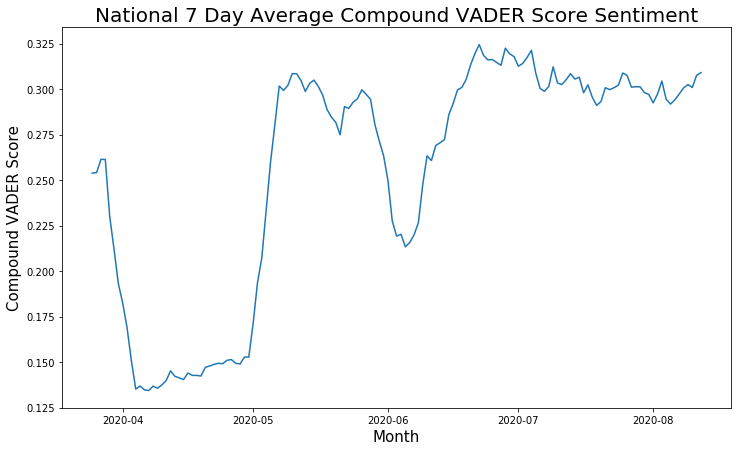

In [230]:
national_sentiment_w_policy(df, metric='compound')